In [ ]:
import torch 
import torch.nn as nn
from torch.nn import Module
import torch.optim as optim

In [83]:
class SiglipVisionConfig:

    def __init__(
        self,
        ### hidden size in the NN (embedding size )
        hidden_size = 768,
        ### number of layers in the NN
        intermediate_size = 3072,
        ## number of heads
        num_attention_heads = 12,
        ## number of layers in the transformer
        num_hidden_layers = 12,
        num_channels = 3,
        image_size = 224,
        patch_size = 16,
        layer_norm_eps = 1e-6,
        attention_dropout = 0.0,
        ## image embedding size 
        num_image_tokens = None,
        **kwargs
    ):
        
        super().__init__()


        self.hidden_size = hidden_size
        self.intermediate_size = intermediate_size
        self.num_attention_heads = num_attention_heads
        self.num_hidden_layers = num_hidden_layers
        self.num_channels = num_channels
        self.image_size = image_size
        self.patch_size = patch_size
        self.attention_dropout = attention_dropout
        self.layer_norm_eps = layer_norm_eps
        self.num_image_tokens = num_image_tokens

In [84]:
class SiglipVisionEmbeddings(Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embed_dim = config.hidden_size
        self.image_size = config.image_size
        self.patch_size = config.patch_size

        self.patch_embedding = nn.Conv2d(
            in_channels = config.num_channels,
            out_channels = self.embed_dim,
            kernel_size = config.patch_size,
            stride = self.patch_size,
            padding = "valid"
        )

        self.num_patches = (self.image_size // self.patch_size)**2
        self.num_positions = self.num_patches
        self.positional_embedding = nn.Embedding(self.num_positions, self.embed_dim)

        self.register_buffer(
            "position_ids",
            torch.arange(self.num_positions).expand((1,-1)),
            persistent = False,
        )
        
    
    def forward(self, pixel_values):
        # batch_size and number_Channel
        _, _, height, width = pixel_values.shape

        patch_embeds = self.patch_embedding(pixel_values)
        # (batch_size, embed_dim, num_patches)
        embeddings = patch_embeds.flatten(2)
        
        embeddings = embeddings.transpose(1,2)

        embeddings = embeddings + self.position_embeddings(self.position_ids)

        return embeddings

In [85]:
class SiglipMLP(Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.fc1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.fc2 = nn.Linear(config.intermediate_size, config.hidden_size)

    def forward(self, hidden_states):
        hidden_states = self.fc1(hidden_states)
        hidden_states = nn.functional.gelu(hidden_states, approximate = 'tanh')
        hidden_states = self.fc2(hidden_states)

        return hidden_states

In [86]:
class SiglipAttention(Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embed_dim = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.head_dim = self.embed_dim // self.num_heads
        self.scale = self.head_dim**-0.5
        self.dropout = config.attention_dropout

        self.k_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.v_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.q_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.out_proj = nn.Linear(self.embed_dim , self.embed_dim)

    def forward(self, hidden_states):
        batch_size, seq_len, _ = hidden_states.size()
        
        query_states = self.q_proj(hidden_states)

        key_states = self.k_proj(hidden_states)

        values_states = self.v_proj(hidden_states)

        query_states = query_states.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1,2)

        key_states = key_states.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1,2)

        values_states = values_states.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1,2)

        attn_weight = (torch.matmul(query_states, key_states.transpose(2,3)) * self.scale)

        if attn_weight.size() != (batch_size, self.num_heads, seq_len, seq_len):
            raise ValueError(f"Attention weight should be of the shape {(batch_size, self.num_heads, seq_len, seq_len)} but it is"
            f"{attn_weight.size()}" 
            )
        

        attn_weight = nn.functional.softmax(attn_weight, dim= -1, dtype = torch.float32).to(query_states.dtype)

        attn_weight = nn.functional.dropout(attn_weight, p=self.dropout, training=self.training)

        attn_output = torch.matmul(attn_weight, values_states)

        if attn_output.size() != (batch_size, self.num_heads, seq_len, self.head_dim):
            raise ValueError(
                f"attn_output should be shape of {(batch_size, self.num_heads, seq_len, self.head_dim)}, but is"
                f"{attn_output.size()}"
            )

        attn_output = attn_output.transpose(1,2).contiguous()

        attn_output = attn_output.reshape(batch_size, seq_len, self.embed_dim)

        attn_output = self.out_proj(attn_output)

        return attn_output, attn_weight

In [87]:
class SiglipEncoderLayer(Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim = config.hidden_size
        self.self_attn = SiglipAttention(config)
        self.layer_norm1 = nn.LayerNorm(self.embed_dim, eps = config.layer_norm_eps)
        self.mlp = SiglipMLP(config)
        self.layer_norm2 = nn.LayerNorm(self.embed_dim, eps = config.layer_norm_eps)

    def forward(self, hidden_states):
        residual = hidden_states
        hidden_states = self.layer_norm1(hidden_states)
        hidden_states, _ = self.self_attn(hidden_states)
        
        hidden_states = hidden_states + residual

        residual = hidden_states
        hidden_states = self.layer_norm2(hidden_states)
        hidden_states = self.mlp(hidden_states)
        hidden_states = hidden_states + residual

        return hidden_states

In [88]:

class SiglipEncoder(Module):
    def __init__(self, config):
        super().__init__()
        
        self.config = config
        self.layers = nn.ModuleList(
            [SiglipEncoderLayer(config) for _ in range(config.num_hidden_layers)]
        )

    def forward(self,inputs_embeds):
        hidden_states = inputs_embeds

        for encoder_layer in self.layers:
            hidden_states = encoder_layer(hidden_states)

        return hidden_states

In [89]:
class SiglipVisionTransformer(Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config
        embed_dim = config.hidden_size
        self.embeddings = SiglipVisionEmbeddings(config)
        self.encoder = SiglipEncoder(config)
        self.post_layernorm = nn.LayerNorm(embed_dim, eps = config.layer_norm_eps)
    
    def forward(self, pixel_values):
        hidden_states = self.embeddings(pixel_values)
        last_hidden_state = self.encoder(hidden_states)
        last_hidden_state = self.post_layernorm(last_hidden_state)
        return last_hidden_state

In [90]:
class SiglipVisionModel(Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config
        self.vision_model = SiglipVisionTransformer(config)
         
    def forward(self, pixel_values):
        ## take in the form [batch_size, channel, height, width] --> [batch_size, number_patch, embedding_dim]
        return self.vision_model(pixel_values)

In [91]:
config = SiglipVisionConfig(hidden_size = 768,
        ### number of layers in the NN
        intermediate_size = 3072,
        ## number of heads
        num_attention_heads = 12,
        ## number of layers in the transformer
        num_hidden_layers = 12,
        num_channels = 3,
        image_size = 1024,
        patch_size = 16,
        layer_norm_eps = 1e-6,
        attention_dropout = 0.0,
        ## image embedding size 
        num_image_tokens = None)

# print(config)
# print(config.attention_dropout)
# print(config.image_size)


my_demo_model = SiglipVisionModel(config=config)
my_demo_model

SiglipVisionModel(
  (vision_model): SiglipVisionTransformer(
    (embeddings): SiglipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=valid)
      (positional_embedding): Embedding(4096, 768)
    )
    (encoder): SiglipEncoder(
      (layers): ModuleList(
        (0-11): 12 x SiglipEncoderLayer(
          (self_attn): SiglipAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): SiglipMLP(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): La

In [104]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

import torch

image shape is : (3648, 5472, 3)
image shape is : (3648, 5472, 3)


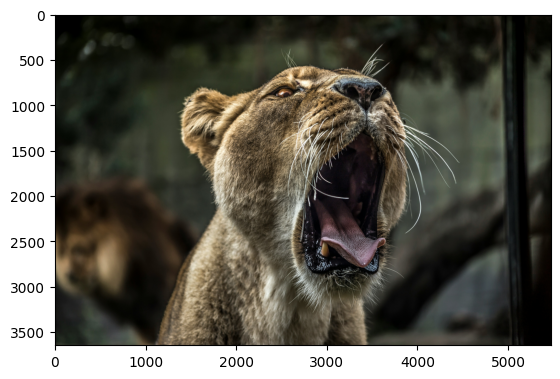

In [105]:
img = cv2.imread("test_images/samuel-scrimshaw-KeUKM5N-e_g-unsplash.jpg")
print(f"image shape is : {img.shape}")
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
print(f"image shape is : {img.shape}")

plt.imshow(img)
plt.show()

In [106]:
img.shape[0]

3648

In [107]:
print(img.shape)
img = img.reshape((img.shape[2], img.shape[0], img.shape[1]))
print(img.shape)

(3648, 5472, 3)
(3, 3648, 5472)


In [108]:
img, img.shape

(array([[[  0,   0,   0, ...,  23,  26,  17],
         [ 24,  27,  18, ...,  61,  68,  60],
         [ 56,  66,  57, ...,  16,  17,   9],
         ...,
         [ 10,  15,   9, ..., 237, 217, 180],
         [225, 203, 164, ...,  69,  57,  45],
         [ 63,  51,  39, ...,  60,  64,  49]],
 
        [[  9,  14,   8, ..., 239, 219, 182],
         [251, 232, 192, ...,  61,  49,  37],
         [ 79,  67,  55, ...,  57,  61,  46],
         ...,
         [105,  85,  60, ..., 173, 157, 124],
         [175, 156, 123, ...,  50,  48,  35],
         [ 58,  50,  39, ...,  10,   7,   2]],
 
        [[102,  82,  55, ..., 172, 153, 120],
         [173, 154, 121, ...,  57,  54,  39],
         [ 69,  60,  45, ...,   9,   8,   3],
         ...,
         [ 40,  41,  33, ...,  70,  63,  47],
         [ 81,  69,  57, ...,  66,  67,  59],
         [ 62,  63,  55, ...,   0,   0,   0]]], dtype=uint8),
 (3, 3648, 5472))

In [109]:
img.reshape((img.shape[1],img.shape[2],img.shape[0])).shape


(3648, 5472, 3)

In [110]:
# convert this image in to an 1024 X 1024 
img  = cv2.resize(img.reshape((img.shape[1],img.shape[2],img.shape[0])), (1024,1024))

print(img.shape)


(1024, 1024, 3)


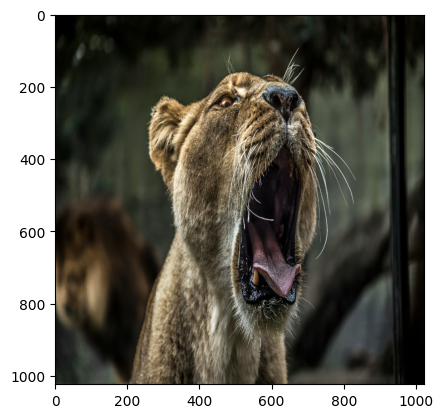

In [111]:
plt.imshow(img)
plt.show()

In [112]:
## lets embedding this image
 
channel, image_height, image_weidth = img.shape
print(channel, image_height, image_weidth)

## embedding dimension  = 768

input_channel = 3
output_channel = 768
patch_size = 16
num_patches = (3*image_height*image_weidth//patch_size)**2
print(num_patches)



1024 1024 3
331776


In [113]:
img.shape

(1024, 1024, 3)

In [114]:
img = img.reshape((3,1024,1024))

In [115]:
img = torch.from_numpy(img).float()
img.shape

torch.Size([3, 1024, 1024])

In [118]:
1024 / 16

64.0

In [120]:
### create embedding vector by using conv2d 

embedding_vec = nn.Conv2d(in_channels=input_channel, out_channels=output_channel, kernel_size=patch_size, stride=patch_size, padding=0)

embedding_image = embedding_vec(img)
embedding_image.shape

torch.Size([768, 64, 64])

In [124]:
torch.unique(embedding_image), len(torch.unique(embedding_image)), torch.max(embedding_image), torch.min(embedding_image)

(tensor([-226.5312, -219.0336, -218.2051,  ...,  238.7668,  241.5246,
          241.6760], grad_fn=<Unique2Backward0>),
 3080181,
 tensor(241.6760, grad_fn=<MaxBackward1>),
 tensor(-226.5312, grad_fn=<MinBackward1>))

In [126]:
### create embedding vector by using conv2d 

embedding_vec = nn.Conv2d(in_channels=input_channel, out_channels=output_channel, kernel_size=patch_size, stride=patch_size, padding="valid")

embedding_image = embedding_vec(img.unsqueeze(0))
print(embedding_image.shape)

torch.unique(embedding_image), len(torch.unique(embedding_image)), torch.max(embedding_image), torch.min(embedding_image)

torch.Size([1, 768, 64, 64])


(tensor([-228.5558, -218.9290, -217.9093,  ...,  233.6586,  234.7126,
          243.4579], grad_fn=<Unique2Backward0>),
 3082113,
 tensor(243.4579, grad_fn=<MaxBackward1>),
 tensor(-228.5558, grad_fn=<MinBackward1>))

In [127]:
## we got embedding here 

In [ ]:
## flatten it

flaten_embeddings = nn.Flatten(start_dim=0,end_dim=-1)
flaten_embeddings

TypeError: Flatten.__init__() got multiple values for argument 'start_dim'

In [139]:
embedding_image.flatten()

tensor([31.9953, 63.2712, 69.1676,  ..., 47.0062, 38.1168, 68.4234],
       grad_fn=<ViewBackward0>)

In [ ]:
class SiglipVisionEmbeddings(Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embed_dim = config.hidden_size
        self.image_size = config.image_size
        self.patch_size = config.patch_size

        self.patch_embedding = nn.Conv2d(
            in_channels = config.num_channels,
            out_channels = self.embed_dim,
            kernel_size = config.patch_size,
            stride = self.patch_size,
            padding = "valid"
        )

        self.num_patches = (self.image_size // self.patch_size)**2
        self.num_positions = self.num_patches
        self.positional_embedding = nn.Embedding(self.num_positions, self.embed_dim)

        self.register_buffer(
            "position_ids",
            torch.arange(self.num_positions).expand((1,-1)),
            persistent = False,
        )
        
    
    def forward(self, pixel_values):
        # batch_size and number_Channel
        _, _, height, width = pixel_values.shape

        patch_embeds = self.patch_embedding(pixel_values)
        # (batch_size, embed_dim, num_patches)
        embeddings = patch_embeds.flatten(2)
        
        embeddings = embeddings.transpose(1,2)

        embeddings = embeddings + self.position_embeddings(self.position_ids)

        return embeddings